In [ ]:
import sys
import os

sys.path.append(os.path.abspath('..'))

from draco import Draco, dict_to_facts, schema_from_dataframe, answer_set_to_dict
from converter import *
import altair as alt
from draco.renderer import AltairRenderer
from llm import *
import re   
from vega_datasets import data as vega_data
from tqdm import tqdm
import random
import torch

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

**Load problems**

In [ ]:
human_problems_dict = torch.load("draco-problems/human_problems.dict")

with open("../paper/draco-problems/human_problems.txt", 'r') as f:
    human_problems = f.read()

print(human_problems)

name: size_negative
A violation occurs if a channel is encoded with size and the corresponding field contains both negative and positive values. The size encoding implies positive magnitude, so it should not be used when the data includes negative values.

name: line_area_with_discrete
A violation occurs when a line or area chart is used and both the x and y channels are encoded with discrete scales. Line and area marks are intended for continuous data and do not function correctly with fully discrete axes.

name: bar_tick_continuous_x_y
A violation occurs if a bar or tick chart is used and both the x and y channels are continuous. These mark types are designed to compare discrete categories and are not suitable for continuous–continuous configurations.

name: shape_without_point
A violation occurs when the shape channel is used but the mark type is not point. The shape encoding is only meaningful when applied to point marks.

name: size_without_point_text
A violation occurs if the siz

In [ ]:
with open("../paper/draco-problems/problems.lp", 'r') as f:
    asp_problems = f.read()

print(asp_problems)

% @hard(size_negative) Do not use size when data is negative as size implies that data is positive.
violation(size_negative) :-
    attribute((encoding,channel),E,size),
    helper((encoding,field),E,F),
    attribute((field,min),F,MIN),
    attribute((field,max),F,MAX),
    MIN < 0,
    MAX > 0.

% @hard(line_area_with_discrete) Line and area cannot have both x and y discrete.
violation(line_area_with_discrete) :-
    attribute((mark,type),M,(line;area)),
    helper(mark_scale_channel,M,T1,x),
    helper(mark_scale_channel,M,T2,y),
    domain(discrete_scale,T1),
    domain(discrete_scale,T2).

% @hard(bar_tick_continuous_x_y) Bar and tick cannot have both x and y continuous.
violation(bar_tick_continuous_x_y) :-
    attribute((mark,type),M,(tick;bar)),
    helper(is_c_c,M).

% @hard(shape_without_point) Shape channel requires point mark.
violation(shape_without_point) :-
    helper((mark,channel),M,shape),
    not attribute((mark,type),M,point).

% @hard(size_without_point_text) Size 

**Load dataset**

In [ ]:
draco_specs_df = pd.read_csv("../paper/datasets/2000/draco_specs.csv")
draco_specs_df

,df,spec,problems
0,chosen_personality.csv,"{""view"": [{""mark"": [{""type"": ""rect"", ""encoding...","rect_without_d_d,linear_color,non_pos_used_bef..."
1,chosen_students.csv,"{""view"": [{""mark"": [{""type"": ""rect"", ""encoding...","ordinal_color,rect_without_d_d,log_scale,log_y..."
2,chosen_anime.csv,"{""view"": [{""mark"": [{""type"": ""line"", ""encoding...","ordinal_scale,c_d_no_overlap_line,ordinal_x"
3,chosen_eplstats.csv,"{""view"": [{""mark"": [{""type"": ""point"", ""encodin...","ordinal_color,log_scale,multi_non_pos,log_y,c_..."
4,chosen_personality.csv,"{""view"": [{""mark"": [{""type"": ""line"", ""encoding...","log_scale,c_d_overlap_line,size_without_point_..."
...,...,...,...
1995,chosen_eplstats.csv,"{""view"": [{""mark"": [{""type"": ""bar"", ""encoding""...","log_scale,multi_non_pos,ordinal_scale,ordinal_..."
1996,chosen_RealEstate.csv,"{""view"": [{""mark"": [{""type"": ""bar"", ""encoding""...","ordinal_color,multi_non_pos,ordinal_scale,no_s..."
1997,chosen_RealEstate.csv,"{""view"": [{""mark"": [{""type"": ""tick"", ""encoding...","ordinal_color,c_d_overlap_tick,log_scale,ordin..."
1998,chosen_liscense.csv,"{""view"": [{""mark"": [{""type"": ""tick"", ""encoding...","log_scale,number_categorical,horizontal_scroll..."


In [ ]:
df_problems = pd.read_csv("./draco-problems/problems.csv")

all_problems = set(list(df_problems["Name"]))
all_problems_dict = dict.fromkeys(all_problems, 0)

In [ ]:
draco_specs_df["problems"]

0       rect_without_d_d,linear_color,non_pos_used_bef...
1       ordinal_color,rect_without_d_d,log_scale,log_y...
2             ordinal_scale,c_d_no_overlap_line,ordinal_x
3       ordinal_color,log_scale,multi_non_pos,log_y,c_...
4       log_scale,c_d_overlap_line,size_without_point_...
                              ...                        
1995    log_scale,multi_non_pos,ordinal_scale,ordinal_...
1996    ordinal_color,multi_non_pos,ordinal_scale,no_s...
1997    ordinal_color,c_d_overlap_tick,log_scale,ordin...
1998    log_scale,number_categorical,horizontal_scroll...
1999    log_scale,c_d_no_overlap_point,log_x,high_card...
Name: problems, Length: 2000, dtype: object

In [ ]:
all_problems = [l.split(",") for l in list(draco_specs_df["problems"])]

for problems in all_problems:
    for problem in problems:
        all_problems_dict[problem] += 1

In [ ]:
all_problems

[['rect_without_d_d', 'linear_color', 'non_pos_used_before_pos'],
 ['ordinal_color',
  'rect_without_d_d',
  'log_scale',
  'log_y',
  'ordinal_scale',
  'ordinal_x'],
 ['ordinal_scale', 'c_d_no_overlap_line', 'ordinal_x'],
 ['ordinal_color',
  'log_scale',
  'multi_non_pos',
  'log_y',
  'c_d_overlap_point',
  'ordinal_scale',
  'non_pos_used_before_pos',
  'only_y',
  'categorical_scale'],
 ['log_scale',
  'c_d_overlap_line',
  'size_without_point_text',
  'log_size',
  'non_pos_used_before_pos'],
 ['log_scale',
  'multi_non_pos',
  'c_d_overlap_tick',
  'non_pos_used_before_pos',
  'high_cardinality_categorical_grt10',
  'same_field',
  'log_y',
  'high_cardinality_shape',
  'shape_without_point',
  'only_y',
  'categorical_scale',
  'size_without_point_text'],
 ['ordinal_shape',
  'high_cardinality_ordinal',
  'only_discrete',
  'shape_without_point',
  'high_cardinality_shape',
  'ordinal_scale',
  'ordinal_x',
  'horizontal_scrolling_x',
  'non_pos_used_before_pos',
  'd_d_rect']

Text(0.5, 1.0, 'Problem distribution across vega-lite visualizations')

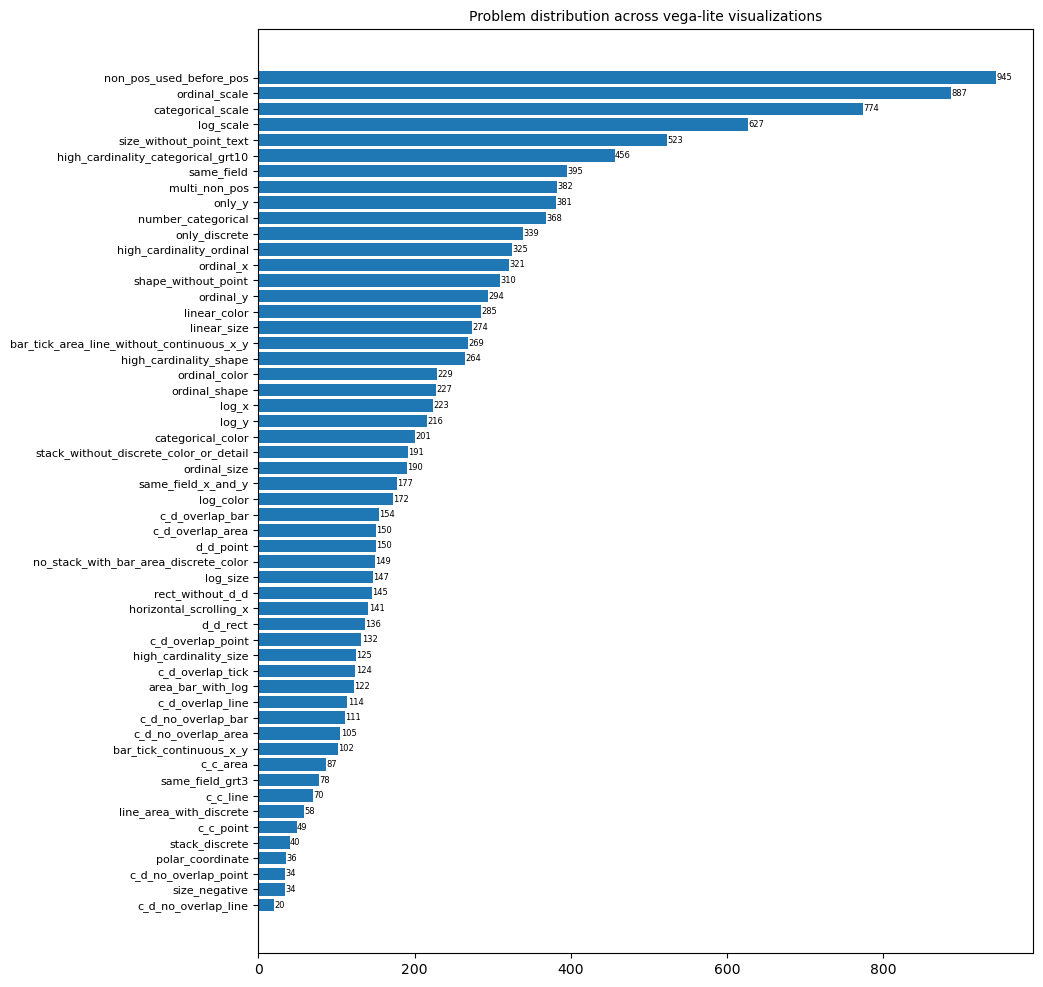

In [ ]:
plt.figure(figsize=(10,12))

x = list(all_problems_dict.values())
y = list(all_problems_dict.keys())

# Sort by values
y, x = zip(*sorted(zip(y, x), key=lambda pair: pair[1]))

# Horizontal bar plot
plt.barh(np.arange(len(x)), x)
plt.yticks(np.arange(len(y)), y, fontsize=8)

# Add value labels to each bar
for i, v in enumerate(x):
    plt.text(v + 0.5, i, str(v), va='center', fontsize=6)

plt.title("Problem distribution across vega-lite visualizations", fontsize = 10)

**Prompts**

In [ ]:
def get_prompt(id, problems, spec):

    prompt1 = f"""
    You are an expert in data visualization design using Vega-Lite.

    ## Input

    ### Problems:
    {problems}

    ### Vega-Lite specification:
    {json.dumps(spec, indent=1)}

    ## Task
    Analyze the Vega-Lite specification and identify which **exact** problem name from the list above are present.

    ## Output Requirements
    - Output **only** a valid JSON array of strings.
    - Each string must be an **exact match** to a problem name from the provided list (excluding the "name :" prefix).
    - Do **not** add explanations, reasoning, or any extra text.
    - If no problems match, return an empty JSON array: []

    ### Example:
    ["problem_A", "problem_B"]
    """

    prompt2 = f"""
    ### Problems:
    {problems}

    You are a Vega-Lite visualization evaluator. Your goal is to read the given Vega-Lite specification and identify any problems from the above list that it exhibits. Focus only on exact matches from the provided names.

    ### Vega-Lite specification:
    {json.dumps(spec, indent=1)}

    ## Output Requirements
    - Output **only** a JSON array of strings.
    - Strings must exactly match a problem name from the list (omit "name :").
    - No explanations, commentary, or extra formatting.
    - If no problems are present, return []

    ### Example:
    ["problem_A", "problem_B"]
    """

    prompt3 = f"""
    ### Problems:
    {problems}

    Analyze the following Vega-Lite specification carefully. Report which of the problem names listed above are present in it. Only use exact matches.

    ### Vega-Lite specification:
    {json.dumps(spec, indent=1)}

    ## Output Requirements
    - Return **only** a JSON array of strings.
    - Each string must match a problem name exactly (exclude "name :").
    - Do not include explanations, notes, or any additional text.
    - Return [] if there are no matches.

    ### Example:
    ["problem_A", "problem_B"]
    """

    prompt4 = f"""
    ### Problems:
    {problems}

    You are tasked with checking the Vega-Lite specification below. Identify all problems from the above list that appear in it. Ensure each match is exact.

    ### Vega-Lite specification:
    {json.dumps(spec, indent=1)}

    ## Output Requirements
    - Provide **only** a JSON array of strings.
    - Each string must be an exact problem name (without "name :").
    - No extra text, reasoning, or commentary.
    - If no problems are found, return []

    ### Example:
    ["problem_A", "problem_B"]
    """

    prompt5 = f"""
    ### Problems:
    {problems}

    Review the Vega-Lite specification and determine which problem names from the list are present. Only include exact matches in your output.

    ### Vega-Lite specification:
    {json.dumps(spec, indent=1)}

    ## Output Requirements
    - Output **only** a JSON array of strings.
    - Strings must exactly match the problem names (ignore the "name :" prefix).
    - Do not provide explanations, notes, or any additional text.
    - If none match, return []

    ### Example:
    ["problem_A", "problem_B"]
    """

    if id == 1: return prompt1
    if id == 2: return prompt2
    if id == 3: return prompt3
    if id == 4: return prompt4
    if id == 5: return prompt5

    raise ValueError("ERROR: Incorrect prompt id")

**Evaluation**

In [ ]:
def run(n_max, rep, filename, draco_specs_df, problems, models = ["llama3.1:8b","llama3.2:3b","gemma3:4b","gemma3:27b","gpt-oss:20b"], prompts = [1]):

    n = len(draco_specs_df)
    if n_max > n: raise ValueError("not enough draco instances to run")

    results = {model: {"outputs": [[] for i in range(rep)], "error_rate": []} for model in models}

    for model in models:
        for i in range(rep):

            random.seed(42)

            count = 0
            error_count = 0

            for idx, row in draco_specs_df.iterrows():

                prompt_id = random.choice(prompts)
                if count % 10 == 0: print(f"[{model} ({i+1}/{rep} - prompt {prompt_id})] {count / n_max * 100} %")

                count += 1
                if count > n_max: break

                draco_spec = json.loads(row["spec"])
                problems_gt = row["problems"]

                # load df and filter out fields that are not included in encodings

                df = pd.read_csv("../paper/datasets/csvs/" + row["df"])

                fields = set([e["field"] for e in draco_spec["view"][0]["mark"][0]["encoding"]])
                df = df[list(fields)]

                vega_spec = draco_to_vega(draco_spec, df)

                # data length is capped to k rows due to prompt adherence loss

                data_key = list(vega_spec["datasets"].keys())[0]
                vega_spec["datasets"][data_key] = random.sample(vega_spec["datasets"][data_key], min(len(df), 20))
                #del vega_spec["datasets"]

                # LLM inference

                prompt = get_prompt(id = prompt_id, problems = problems, spec = vega_spec)

                timeout = 70 if model == "gpt-oss:20b" else 15
                out = llm_chat_timed(model, prompt, verbose=False, timeout=timeout)
                
                #print(green(prompt))

                # Extract from ```json ... ```

                if out != None:

                    match = re.search(r'```json\s*(.*?)\s*```', out, re.DOTALL)
                    if match: out = match.group(1)

                    print(blue(out))

                problems_pred = None

                try:

                    problems_pred = json.loads(out)
                    pred = set([problem for problem in problems_pred])

                except Exception as e:

                    problems_pred = None
                    error_count += 1

                    print(red(f"[{model} ({i+1}/{rep}) - prompt {prompt_id}] > ERROR at LLM out decoding"), e)

                results[model]["outputs"][i].append({"spec": vega_spec, "problems_gt" : problems_gt, "problems_pred": problems_pred})

            error_rate = error_count / n_max * 100
            results[model]["error_rate"].append(error_rate)

            print(green(f"[{model} ({i+1}/{rep} - prompt {prompt_id})] > ERROR RATE : {error_rate} %\n"))
            torch.save(results, f"./outputs/{filename}.out")

    return results

In [ ]:
def get_problems(problems_dict, n = None):

    if n == None: n = len(problems_dict)

    result = ""
    items = list(problems_dict.items())[:n]

    for k,v in items:
        result += "name: " + k + "\n" + v + "\n\n"

    return result

res = get_problems(human_problems_dict, n = 2)
print(res)

name: size_negative
A violation occurs if a channel is encoded with size and the corresponding field contains both negative and positive values. The size encoding implies positive magnitude, so it should not be used when the data includes negative values.

name: line_area_with_discrete
A violation occurs when a line or area chart is used and both the x and y channels are encoded with discrete scales. Line and area marks are intended for continuous data and do not function correctly with fully discrete axes.




**Experiment 1**

In [ ]:
#models = ["llama3.1:8b","llama3.2:3b","gemma3:4b","gemma3:27b","gpt-oss:20b"]
models = ["gpt-oss:20b","llama3.1:8b","gemma3:27b"]

# CORRER UNA VEZ MÁS GEMMA 27B

for model in models:
    results = run(n_max = 2000, rep = 5, filename = f"3_9_{model}_2000", draco_specs_df = draco_specs_df, problems = human_problems, prompts = [1,2,3,4,5], models = [model])

[gpt-oss:20b (1/5 - prompt 1)] 0.0 %
["rect_without_d_d","linear_color"]
["rect_without_d_d", "log_scale", "log_y", "ordinal_x", "ordinal_color", "ordinal_scale"]
["ordinal_x","ordinal_scale"]
timeout
[gpt-oss:20b (1/5) - prompt 5] > ERROR at LLM out decoding the JSON object must be str, bytes or bytearray, not NoneType
["log_size", "size_without_point_text", "log_scale"]
["shape_without_point","size_without_point_text","bar_tick_area_line_without_continuous_x_y","same_field","only_discrete","multi_non_pos","only_y","high_cardinality_shape","log_scale","ordinal_scale","ordinal_y","log_y"]
["shape_without_point","only_discrete","high_cardinality_shape","ordinal_x","ordinal_shape"]
["only_y","ordinal_scale","ordinal_size","only_discrete"]
["shape_without_point","size_without_point_text","bar_tick_area_line_without_continuous_x_y","only_discrete","multi_non_pos","only_y","high_cardinality_shape","ordinal_y","ordinal_shape","ordinal_size","ordinal_scale","log_scale"]
["shape_without_point"

Process Process-250793:
Traceback (most recent call last):
  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/martin/Desktop/visdecode/llm.py", line 11, in _run_chat
    res = ollama.chat(
          ^^^^^^^^^^^^
  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/site-packages/ollama/_client.py", line 333, in chat
    return self._request(
           ^^^^^^^^^^^^^^
  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/site-packages/ollama/_client.py", line 178, in _request
    return cls(**self._request_raw(*args, **kwargs).json())
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


KeyboardInterrupt: 

  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/site-packages/ollama/_client.py", line 118, in _request_raw
    r = self._client.request(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/site-packages/httpx/_client.py", line 825, in request
    return self.send(request, auth=auth, follow_redirects=follow_redirects)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/site-packages/httpx/_client.py", line 914, in send
    response = self._send_handling_auth(
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/site-packages/httpx/_client.py", line 942, in _send_handling_auth
    response = self._send_handling_redirects(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martin/miniconda3/envs/pytorch/lib/python3.11/site-packages/httpx/_client.py", line 979, in _send